# Approach 1 Clustering

## Importing Necessary modules

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
mfcc_dir = r'C:\Users\veers\Machine learning\DS203\Final project\MFCC-files-v2'

# Load the MFCC data into a dictionary for easy access
mfcc_data = {}
for file in os.listdir(mfcc_dir):
    if file.endswith('.csv'):
        song_num = file.split('-')[0]  # Extract song number
        file_path = os.path.join(mfcc_dir, file)
        mfcc_data[song_num] = pd.read_csv(file_path, header=None)

## EDA of the dataset


In [4]:
def basic_info(data):
    print("Number of Files:", len(data))
    sample_file = list(data.values())[0]
    print("Sample File Shape:", sample_file.shape)
    print("MFCC Coefficients per Song:", sample_file.shape[0])
    print("Columns (Time Segments):", sample_file.shape[1])

basic_info(mfcc_data)

Number of Files: 116
Sample File Shape: (20, 9769)
MFCC Coefficients per Song: 20
Columns (Time Segments): 9769


In [5]:
missing_values = {song_num: df.isnull().sum().sum() for song_num, df in mfcc_data.items()}
missing_songs = {k: v for k, v in missing_values.items() if v > 0}

print("Songs with Missing Values:", missing_songs)

Songs with Missing Values: {}


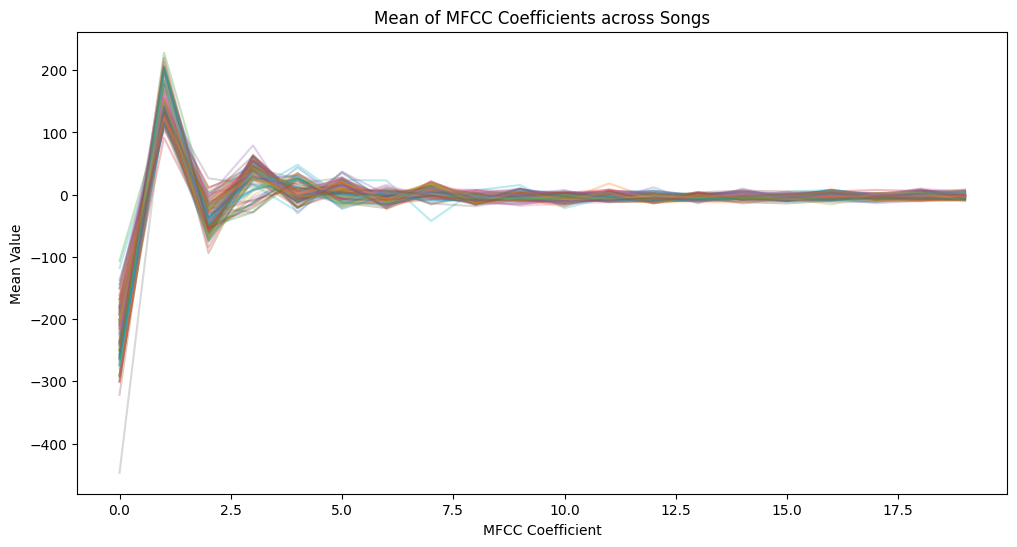

In [6]:
mean_values = [df.mean(axis=1) for df in mfcc_data.values()]
std_values = [df.std(axis=1) for df in mfcc_data.values()]

# Plot the mean values across songs
plt.figure(figsize=(12, 6))


plt.title("Mean of MFCC Coefficients across Songs")
for idx, mean in enumerate(mean_values):
    plt.plot(mean, label=f'Song {idx+1}', alpha=0.3)
plt.xlabel("MFCC Coefficient")
plt.ylabel("Mean Value")
plt.show()

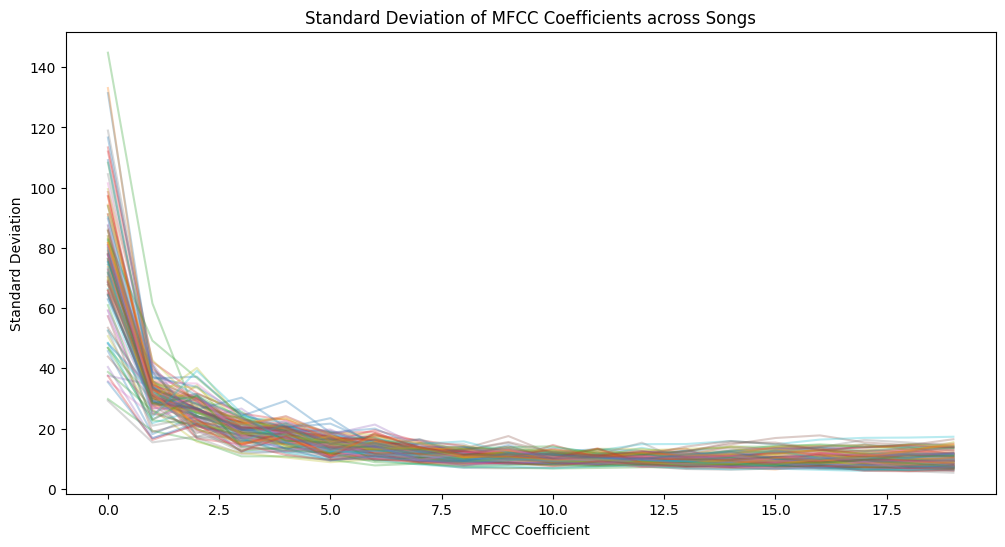

In [12]:
plt.figure(figsize=(12, 6))
plt.title("Standard Deviation of MFCC Coefficients across Songs")
for idx, std in enumerate(std_values):
    plt.plot(std, label=f'Song {idx+1}', alpha=0.3)
plt.xlabel("MFCC Coefficient")
plt.ylabel("Standard Deviation")
plt.show()

In [ ]:
sample_song = list(mfcc_data.values())[0]  # Use any song as an example
plt.figure(figsize=(10, 8))
sns.heatmap(sample_song.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of MFCC Coefficients for a Sample Song")
plt.show()

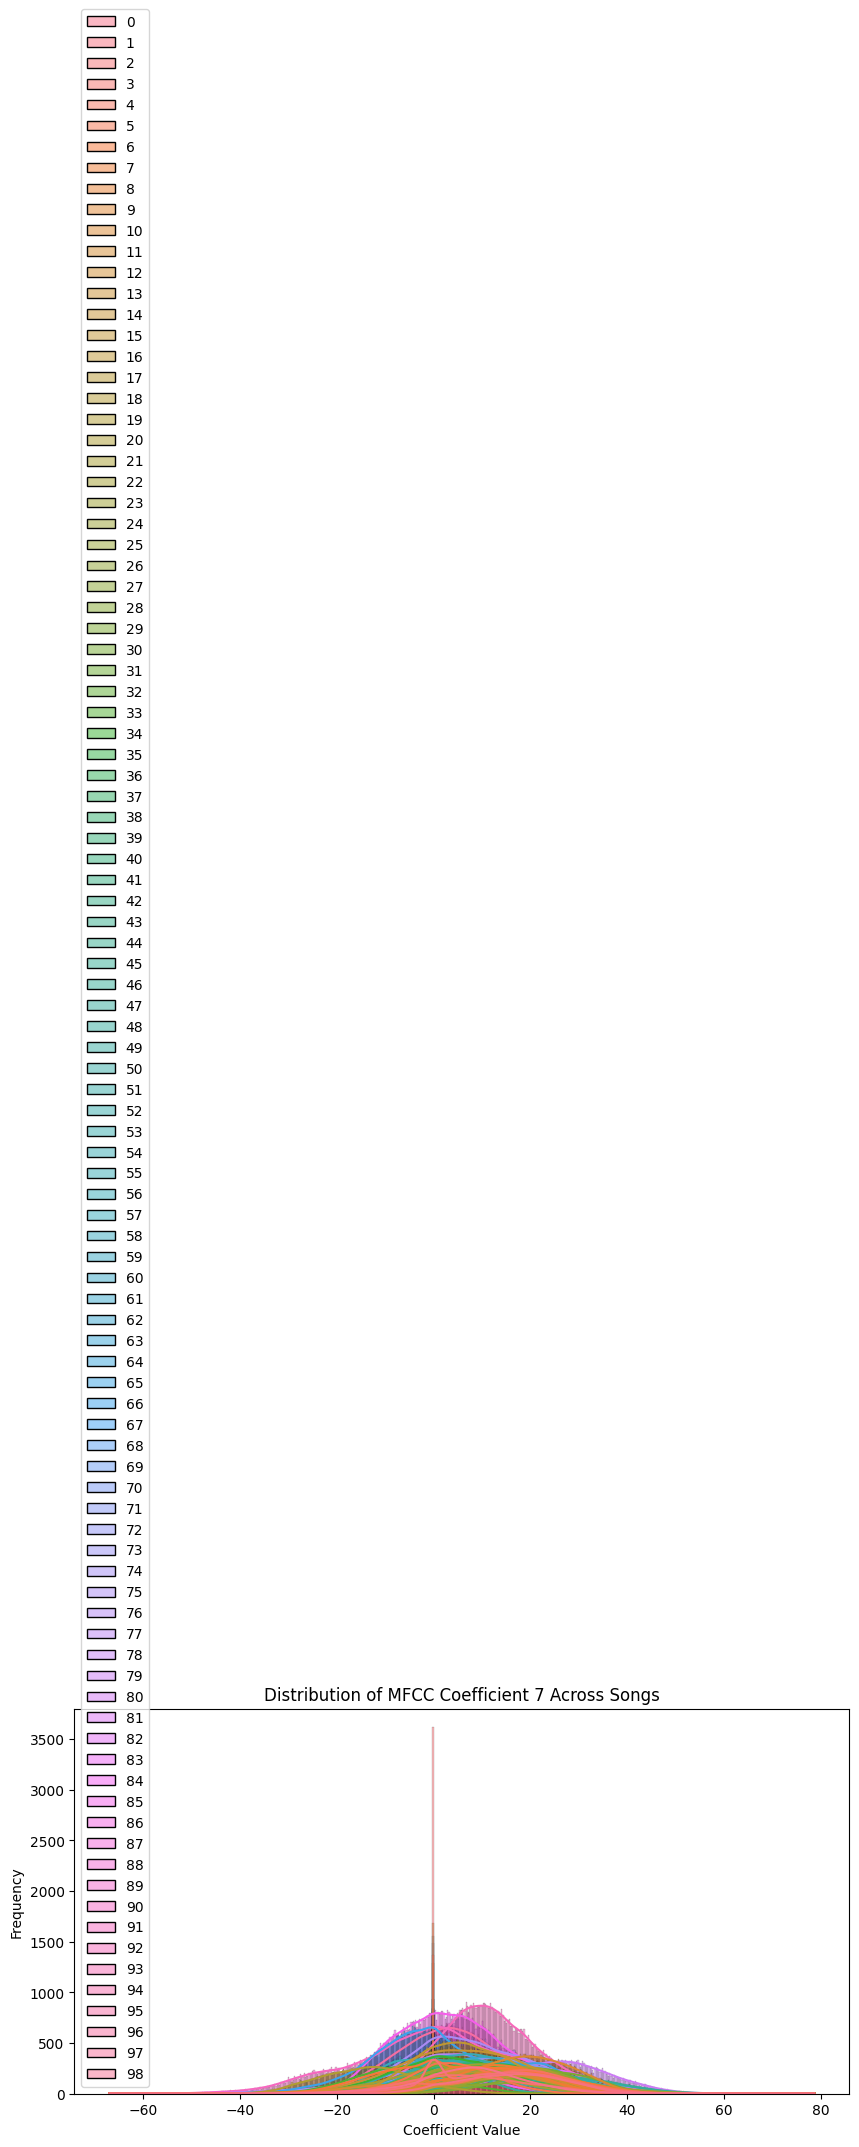

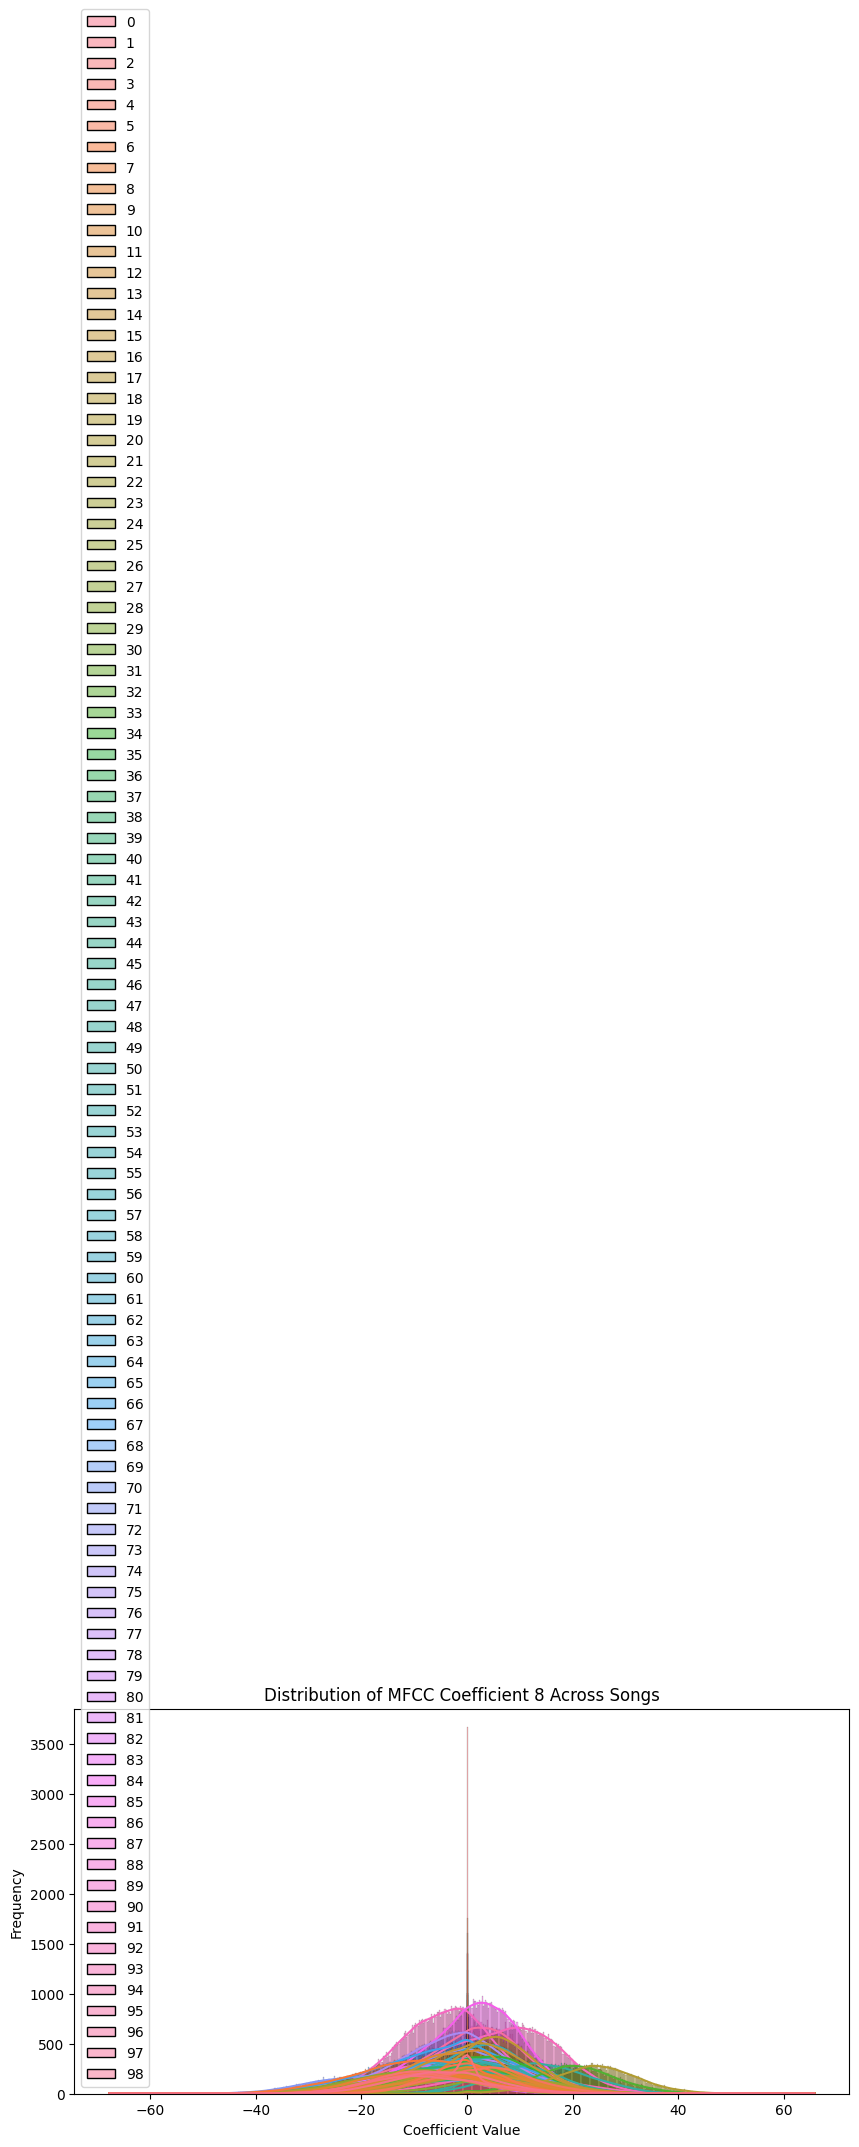

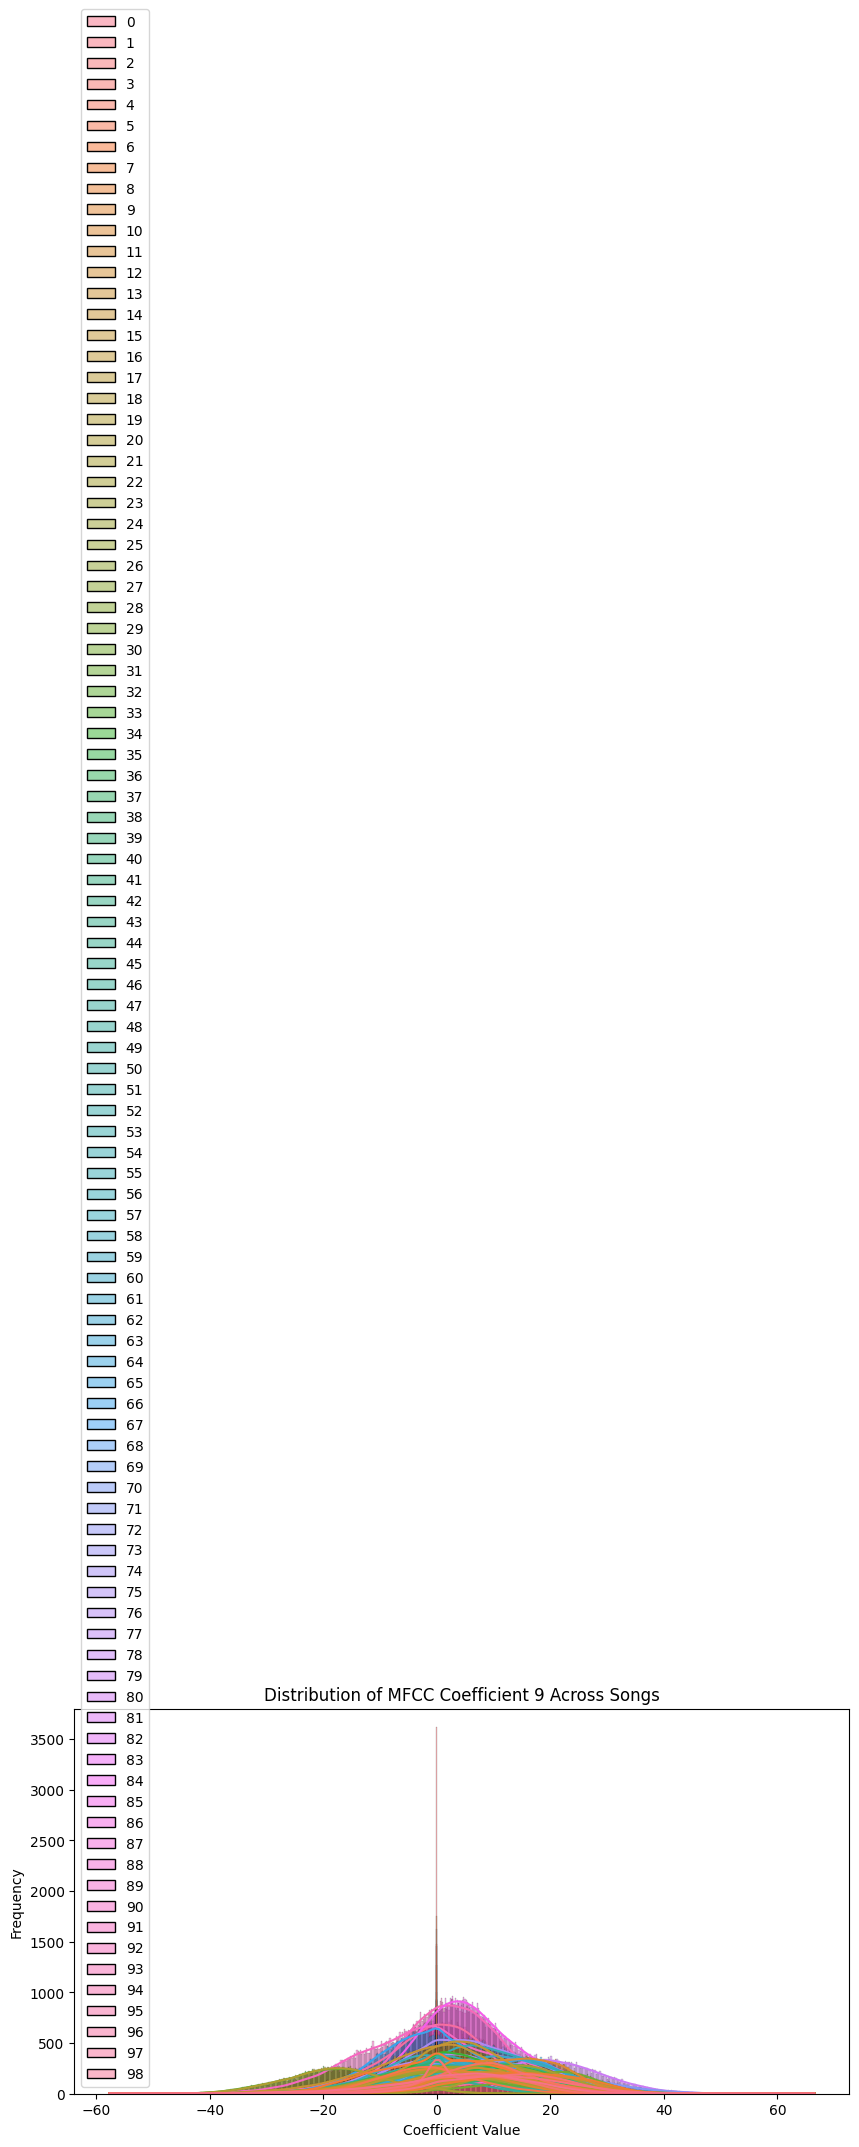

In [10]:
for i in range(6,9):  # Change 5 to 20 if you want all coefficients
    plt.figure(figsize=(10, 5))
    sns.histplot([df.iloc[i].values for df in mfcc_data.values()], kde=True)
    plt.title(f"Distribution of MFCC Coefficient {i+1} Across Songs")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Frequency")
    plt.show()

## Agglomerative clustering of Songs

In [ ]:
import os
import pandas as pd
import librosa
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

mfcc_dir = r'C:\Users\veers\Machine learning\DS203\Final project\MFCC-files-v2'
mfcc_data = {}

for file in os.listdir(mfcc_dir):
    if file.endswith('.csv'):
        song_num = file.split('-')[0]
        file_path = os.path.join(mfcc_dir, file)
        mfcc_data[song_num] = pd.read_csv(file_path, header=None)

all_mfcc = pd.concat(mfcc_data.values(), axis=0).reset_index(drop=True)

engineered_features = pd.DataFrame()
sr = 44100
librosa_weight = 3

for song_number, mfcc_df in mfcc_data.items():
    mean_mfcc = mfcc_df.mean(axis=1)
    std_mfcc = mfcc_df.std(axis=1)
    skew_mfcc = mfcc_df.skew(axis=1)
    kurtosis_mfcc = mfcc_df.kurtosis(axis=1)

    delta_mfcc = librosa.feature.delta(mfcc_df.values, order=1)
    delta2_mfcc = librosa.feature.delta(mfcc_df.values, order=2)
    delta_mean = delta_mfcc.mean(axis=1)
    delta2_mean = delta2_mfcc.mean(axis=1)

    y = mfcc_df.mean(axis=0).values
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()

    hnr = librosa.effects.harmonic(y).mean()

    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
    pitch = np.max(pitches) if pitches.size > 0 else 0

    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = chroma.mean(axis=1)

    song_length = librosa.get_duration(y=y, sr=sr)

    engineered_features = pd.concat([engineered_features,
                                     pd.DataFrame({
                                         'song_number': song_number,
                                         'mean_mfcc': mean_mfcc.mean(),
                                         'std_mfcc': std_mfcc.mean(),
                                         'skew_mfcc': skew_mfcc.mean(),
                                         'kurtosis_mfcc': kurtosis_mfcc.mean(),
                                         'delta_mean': delta_mean.mean() * librosa_weight,
                                         'delta2_mean': delta2_mean.mean() * librosa_weight,
                                         'spectral_centroid': spectral_centroid * librosa_weight,
                                         'spectral_rolloff': spectral_rolloff * librosa_weight,
                                         'hnr': hnr * librosa_weight,
                                         'pitch': pitch * librosa_weight,
                                         'tempo': tempo * librosa_weight,
                                         'chroma_mean': chroma_mean.mean() * librosa_weight,
                                         'song_length': song_length
                                     }, index=[0])])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(engineered_features.drop(columns=['song_number']))

pca = PCA(n_components=0.95)
pca_features = pca.fit_transform(scaled_features)

print("Explained Variance by Selected Components:", np.sum(pca.explained_variance_ratio_))

agglo = AgglomerativeClustering(n_clusters=6, linkage='ward')
agglo_labels = agglo.fit_predict(pca_features)

silhouette_agglo = silhouette_score(pca_features, agglo_labels)
print(f"Silhouette Score for Agglomerative Clustering: {silhouette_agglo}")

engineered_features['agglo_label'] = agglo_labels
engineered_features.to_csv('improved_agglomerative_clustering_results.csv', index=False)

print(engineered_features[['song_number', 'agglo_label']])



c:\Users\veers\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
c:\Users\veers\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
c:\Users\veers\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
c:\Users\veers\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
c:\Users\veers\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
c:\Users\veers\AppData\Local\Programs\Python\Python311\Lib\s

Explained Variance by Selected Components: 0.9577219067527954
Silhouette Score for Agglomerative Clustering: 0.1778788931256548
   song_number  agglo_label
0           01            4
0           02            4
0           03            5
0           04            0
0           05            2
..         ...          ...
0           95            4
0           96            2
0           97            2
0           98            5
0           99            1

[116 rows x 2 columns]


## Pairwise plots of features

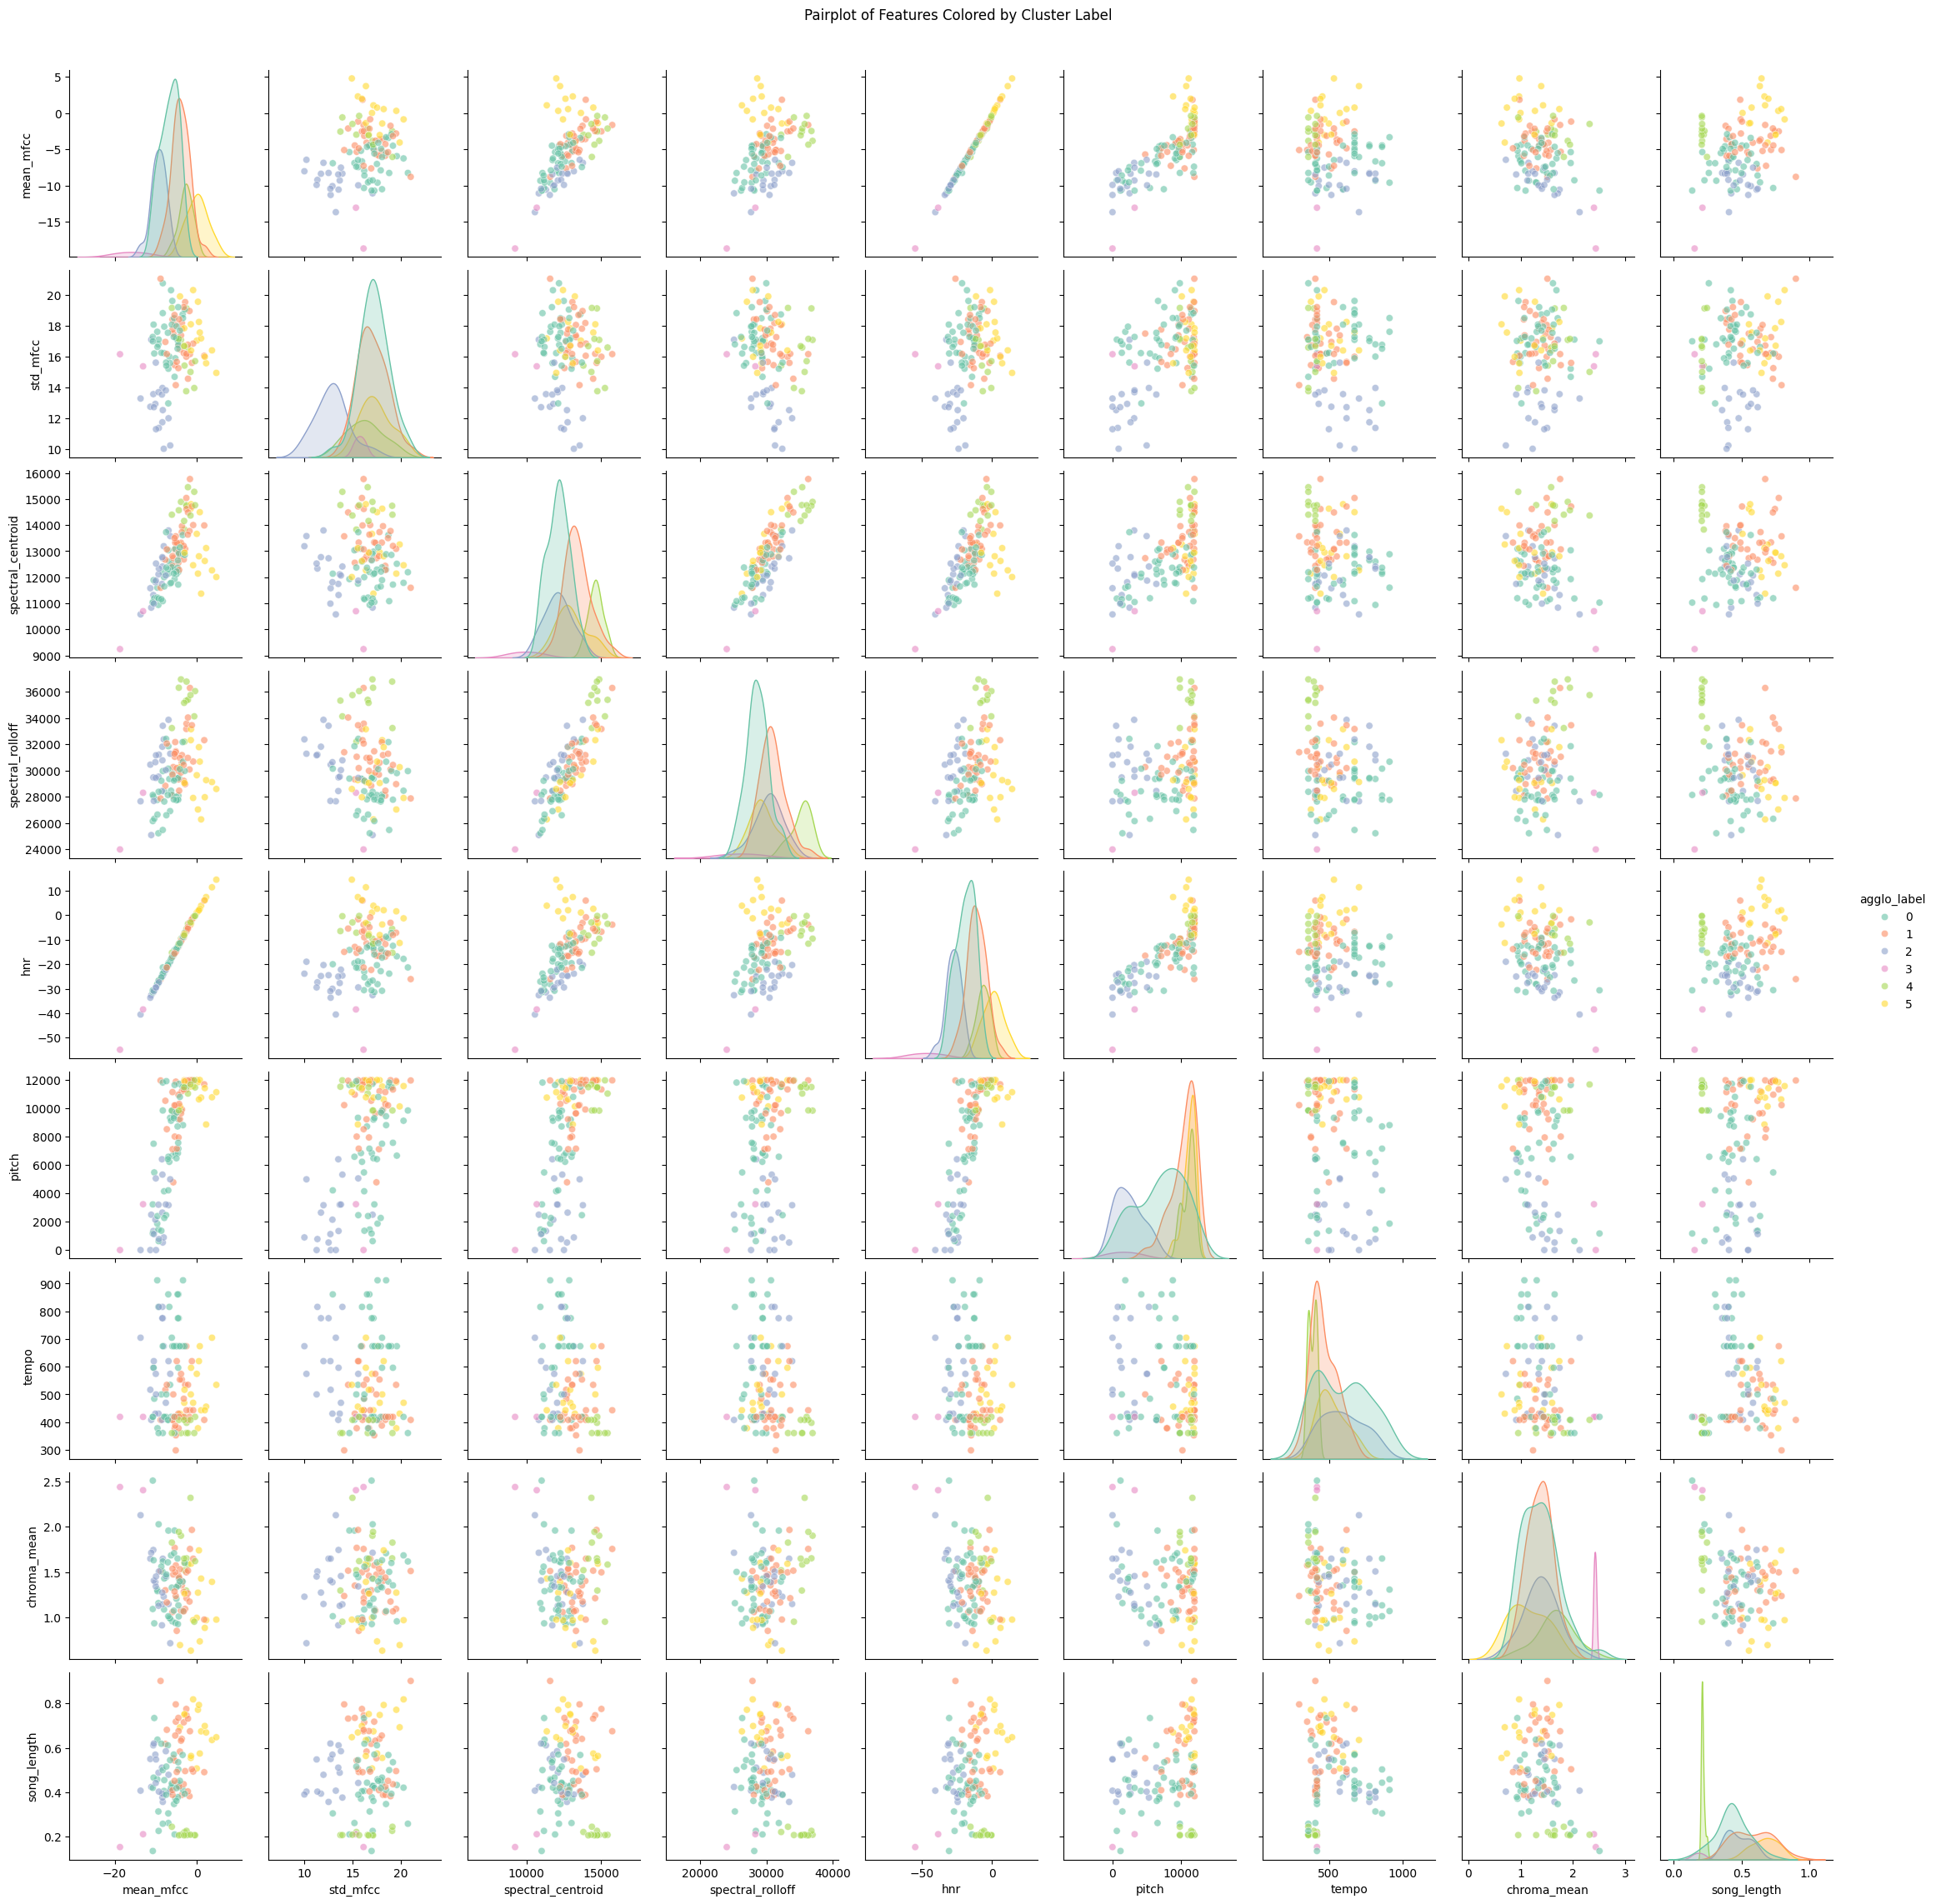

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv(r'C:\Users\veers\Machine learning\DS203\Final project\improved_agglomerative_clustering_results.csv')

# Define features for the pairplot
pairplot_features = [
    'mean_mfcc', 'std_mfcc', 'spectral_centroid', 'spectral_rolloff', 
    'hnr', 'pitch', 'tempo', 'chroma_mean', 'song_length', 'agglo_label'
]

# Convert 'agglo_label' to categorical for coloring in the pairplot
data['agglo_label'] = data['agglo_label'].astype('category')

# Create the pairplot
sns.pairplot(data[pairplot_features], hue='agglo_label', palette="Set2", plot_kws={'alpha': 0.6})
plt.suptitle("Pairplot of Features Colored by Cluster Label", y=1.02)
plt.show()


## Scatter plot of clustering

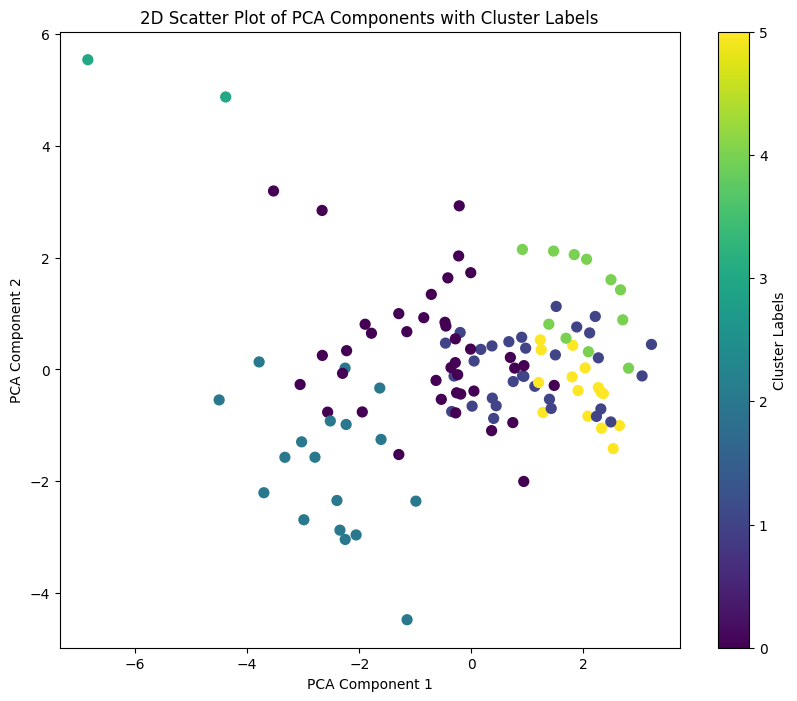

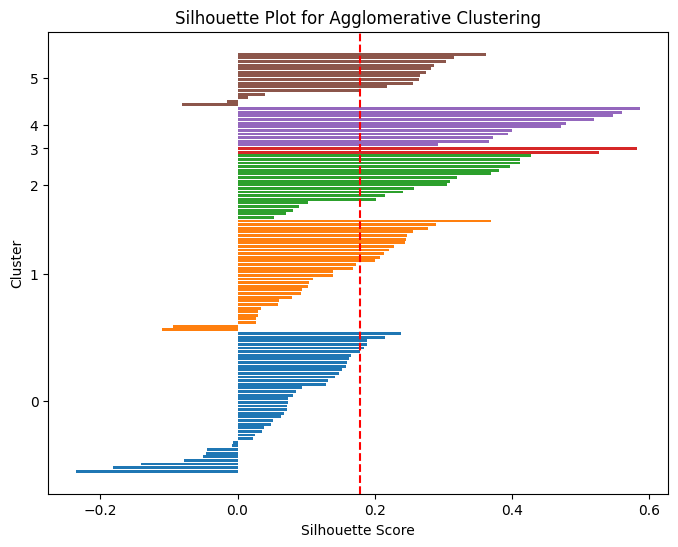

KeyError: 'agglo_label'

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_samples

# ========================
# Plot 1: 2D Scatter Plot of PCA Components with Cluster Labels
# ========================
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=agglo_labels, cmap='viridis', s=50)
plt.colorbar(scatter, label='Cluster Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D Scatter Plot of PCA Components with Cluster Labels')
plt.show()

# ========================
# Plot 2: Silhouette Plot
# ========================
silhouette_vals = silhouette_samples(pca_features, agglo_labels)
y_ticks = []
y_lower, y_upper = 0, 0

plt.figure(figsize=(8, 6))
for i in range(6):  # 6 clusters
    ith_cluster_silhouette_values = silhouette_vals[agglo_labels == i]
    ith_cluster_silhouette_values.sort()
    y_upper += len(ith_cluster_silhouette_values)
    plt.barh(range(y_lower, y_upper), ith_cluster_silhouette_values, edgecolor='none')
    y_ticks.append((y_lower + y_upper) / 2)
    y_lower = y_upper

plt.axvline(silhouette_agglo, color="red", linestyle="--")  # Average silhouette score
plt.yticks(y_ticks, range(6))
plt.ylabel("Cluster")
plt.xlabel("Silhouette Score")
plt.title("Silhouette Plot for Agglomerative Clustering")
plt.show()

# ========================
# Plot 3: Mean of Features Across Clusters
# ========================
clustered_means = engineered_features.groupby('agglo_label').mean()

# Plot selected feature means by cluster
selected_features = ['mean_mfcc', 'spectral_centroid', 'tempo', 'hnr', 'chroma_mean']
clustered_means[selected_features].plot(kind='bar', figsize=(10, 8), colormap='viridis')
plt.title('Mean of Selected Features Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Feature Mean Value')
plt.legend(title='Features')
plt.show()


In [15]:
# Group song numbers by cluster label
clustered_songs = engineered_features.groupby('agglo_label')['song_number'].apply(list)

# Display the song numbers classified to each cluster
for cluster_label, song_numbers in clustered_songs.items():
    print(f"Cluster {cluster_label}: {song_numbers}")


Cluster 0: ['04', '07', '101', '105', '107', '11', '14', '16', '19', '22', '24', '25', '27', '30', '33', '37', '38', '43', '49', '52', '54', '56', '59', '62', '64', '65', '66', '68', '70', '73', '74', '75', '76', '79', '82', '85', '88', '91', '92']
Cluster 1: ['06', '10', '104', '106', '109', '110', '112', '113', '115', '15', '21', '23', '32', '34', '36', '39', '40', '41', '42', '48', '55', '57', '58', '60', '71', '72', '77', '78', '80', '94', '99']
Cluster 2: ['05', '09', '100', '102', '111', '18', '26', '28', '29', '46', '50', '51', '63', '83', '84', '93', '96', '97']
Cluster 3: ['116', '67']
Cluster 4: ['01', '02', '108', '17', '31', '35', '61', '81', '87', '90', '95']
Cluster 5: ['03', '08', '103', '114', '12', '13', '20', '44', '45', '47', '53', '69', '86', '89', '98']
